In [3]:
import pandas as pd
import numpy as np

# Şimdi, veri setimizi yükleyeceğiz ve sütunların bazı ilk satırlarına ve veri türlerine bakacağız:
data = pd.read_excel('dolar_degerleri.xlsx')
print (data.head(10))

     Tarih  dolar_degerleri
0  1996-11         0.098234
1  1996-12         0.104443
2  1997-01         0.111818
3  1997-02         0.118907
4  1997-03         0.124559
5  1997-04         0.130590
6  1997-05         0.136767
7  1997-06         0.143733
8  1997-07         0.152826
9  1997-08         0.162989


In [4]:
print ('\n Data Types:')
print (data.dtypes)


 Data Types:
Tarih               object
dolar_degerleri    float64
dtype: object


In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_excel('dolar_degerleri.xlsx', parse_dates=['Tarih'], index_col='Tarih',date_parser=dateparse)
print ('\n Parsed Data:')
print (data.head())


 Parsed Data:
            dolar_degerleri
Tarih                      
1996-11-01         0.098234
1996-12-01         0.104443
1997-01-01         0.111818
1997-02-01         0.118907
1997-03-01         0.124559


In [8]:
data.index

DatetimeIndex(['1996-11-01', '1996-12-01', '1997-01-01', '1997-02-01',
               '1997-03-01', '1997-04-01', '1997-05-01', '1997-06-01',
               '1997-07-01', '1997-08-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='Tarih', length=278, freq=None)

In [11]:
ts = data['dolar_degerleri']
ts.head(10)

Tarih
1996-11-01    0.098234
1996-12-01    0.104443
1997-01-01    0.111818
1997-02-01    0.118907
1997-03-01    0.124559
1997-04-01    0.130590
1997-05-01    0.136767
1997-06-01    0.143733
1997-07-01    0.152826
1997-08-01    0.162989
Name: dolar_degerleri, dtype: float64

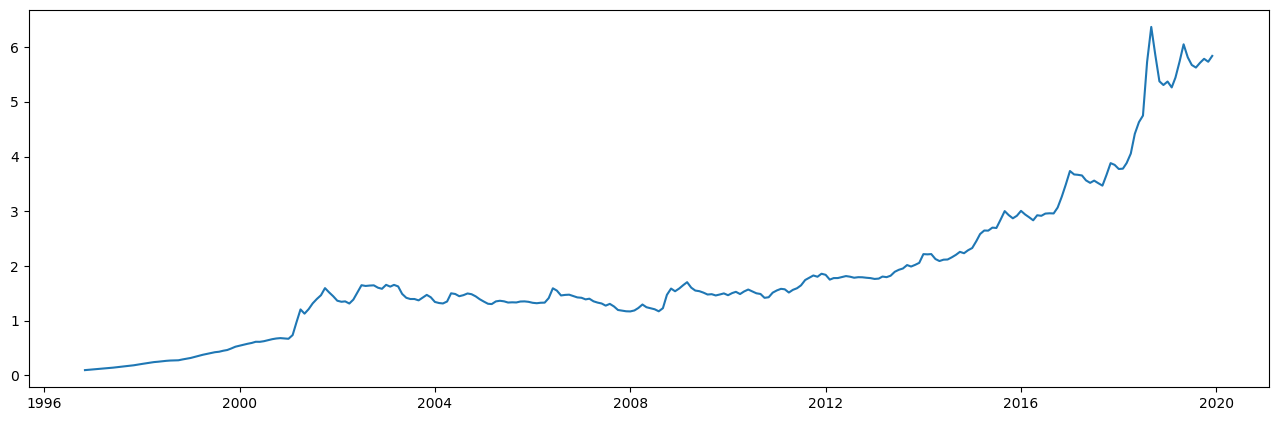

In [14]:
# dolar değerlerinin zamanla değiştiğini grafikte gösterelim.
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5), dpi=100)
plt.plot(ts)

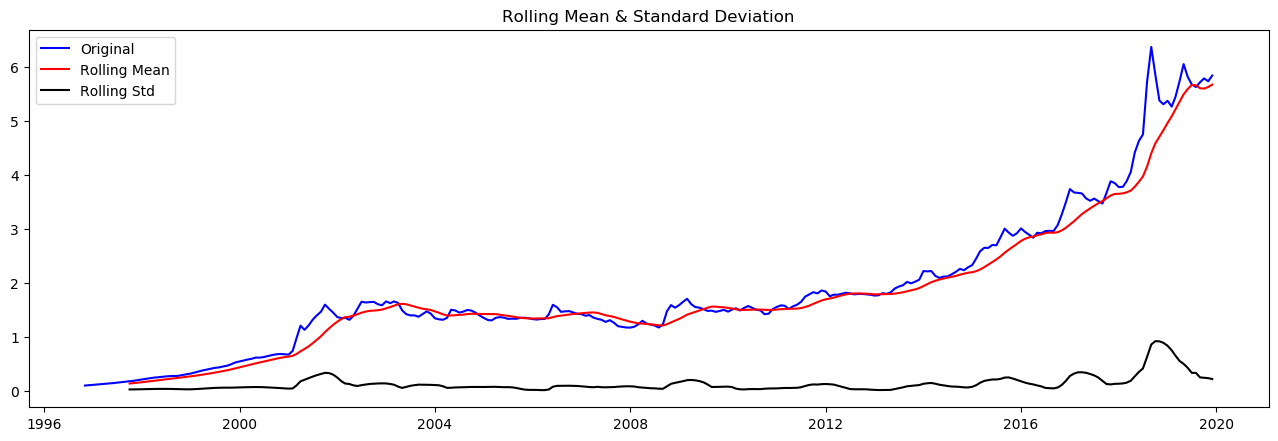

Results of Dickey-Fuller Test:
Test Statistic                   2.385741
p-value                          0.999003
#Lags Used                       5.000000
Number of Observations Used    272.000000
Critical Value (1%)             -3.454622
Critical Value (5%)             -2.872225
Critical Value (10%)            -2.572464
dtype: float64


In [15]:
## Dickey Fuller Testi

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

plt.figure(figsize=(16,5), dpi=100)
plt.savefig('standart_sapma.png')
test_stationarity(ts)


In [16]:
# aşağıdaki seri durağan değildir.

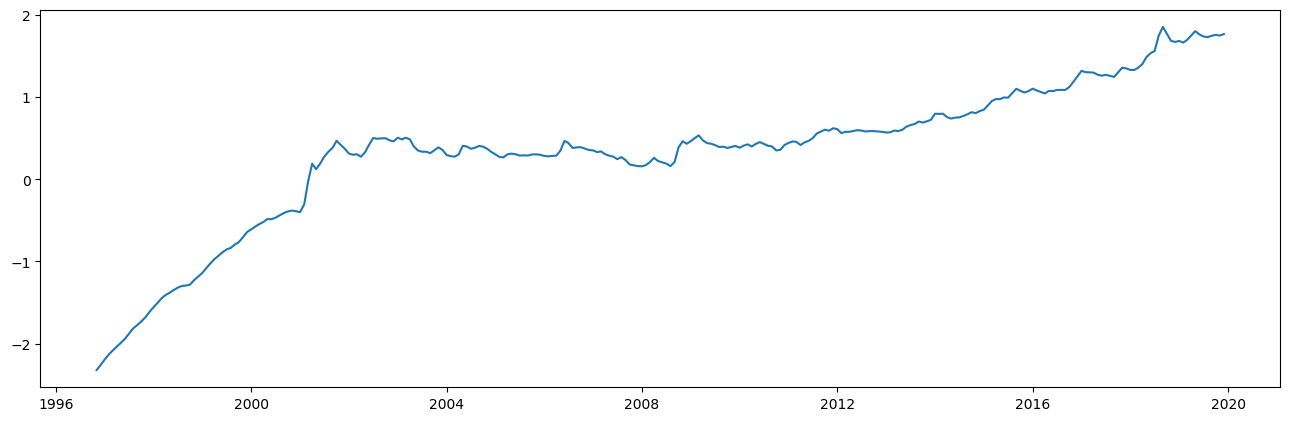

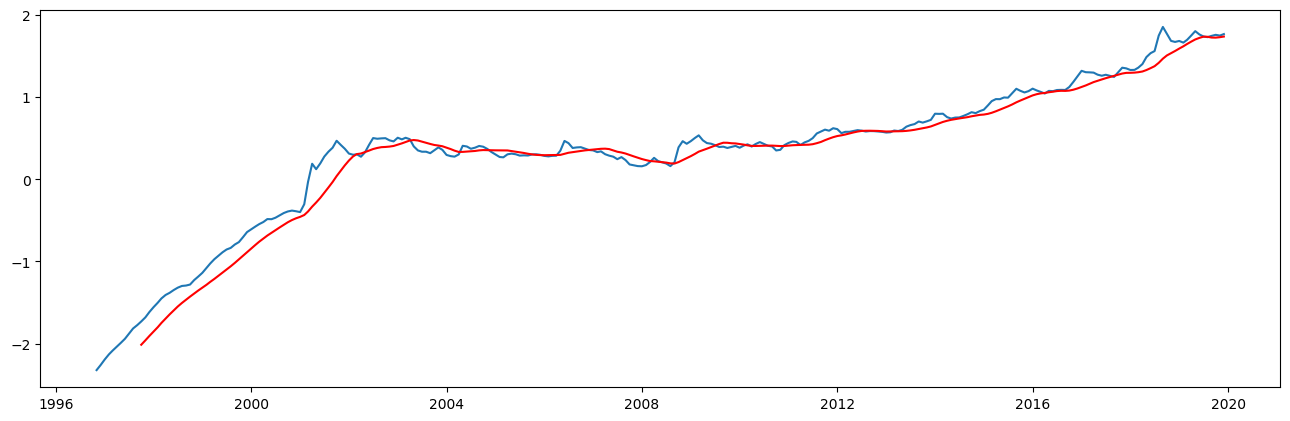

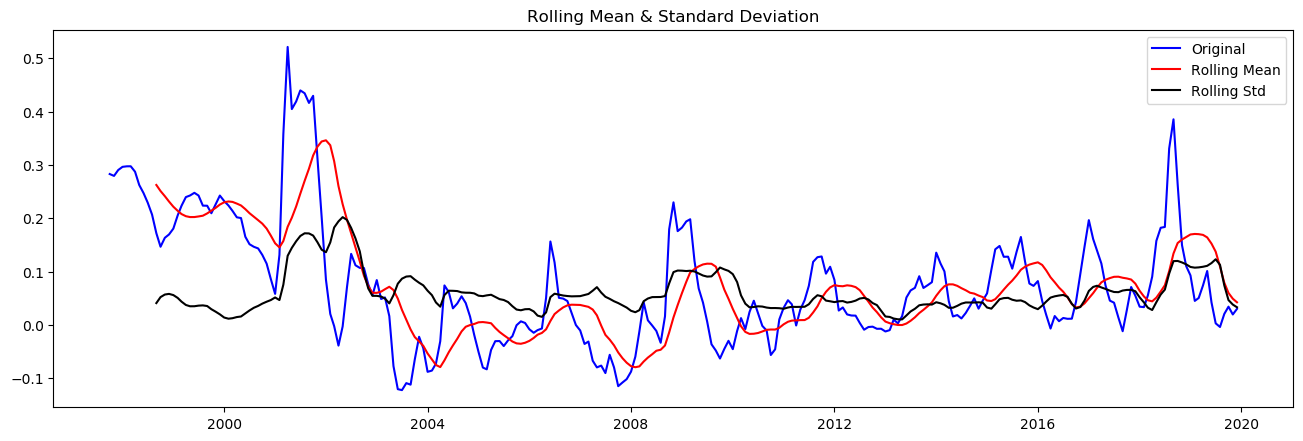

Results of Dickey-Fuller Test:
Test Statistic                  -4.380356
p-value                          0.000322
#Lags Used                       3.000000
Number of Observations Used    263.000000
Critical Value (1%)             -3.455461
Critical Value (5%)             -2.872593
Critical Value (10%)            -2.572660
dtype: float64


In [17]:
# Seriyi durağan hale getirme
# test_statistic değeri Critical Value%1,%5%10 değerlerinden küçük olmalı.
ts_log = np.log(ts)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(ts_log)

moving_avg = ts_log.rolling(12).mean()
plt.figure(figsize=(16,5), dpi=100)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

plt.figure(figsize=(16,5), dpi=100)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

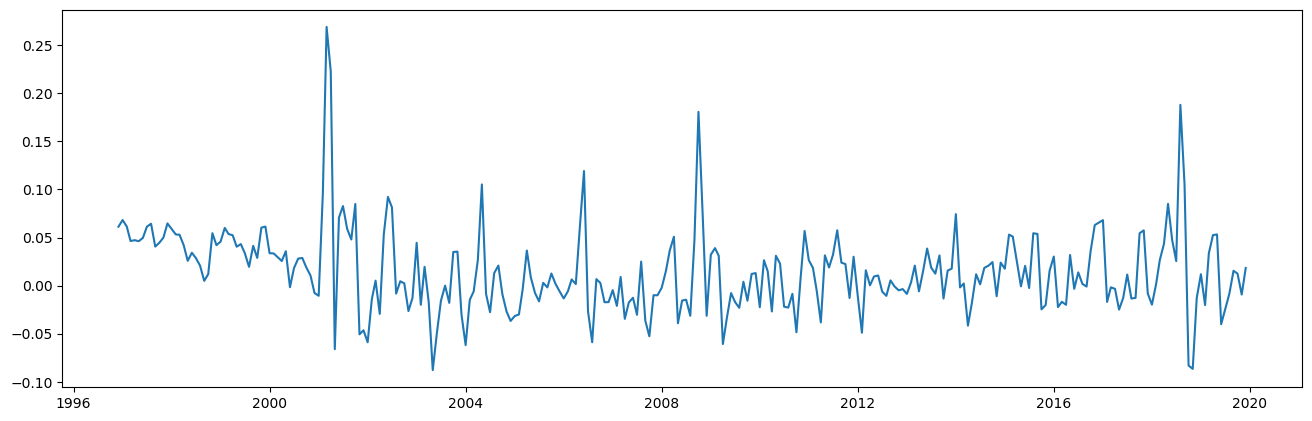

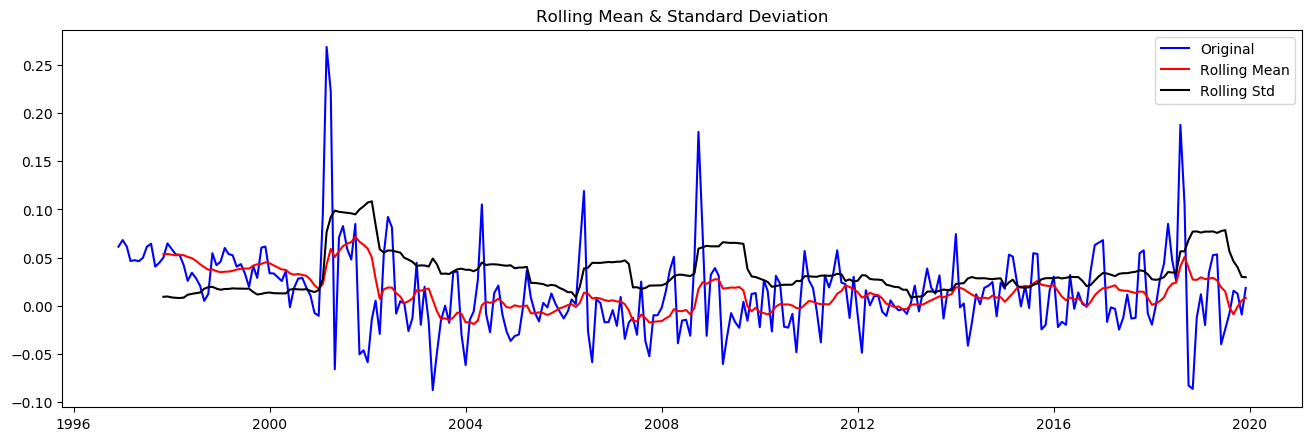

Results of Dickey-Fuller Test:
Test Statistic                -7.449939e+00
p-value                        5.705723e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.740000e+02
Critical Value (1%)           -3.454444e+00
Critical Value (5%)           -2.872147e+00
Critical Value (10%)          -2.572422e+00
dtype: float64


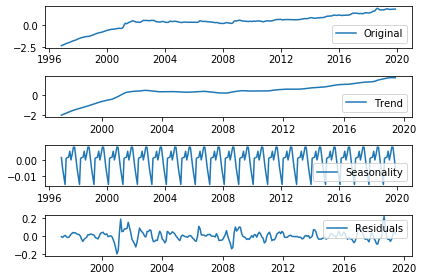

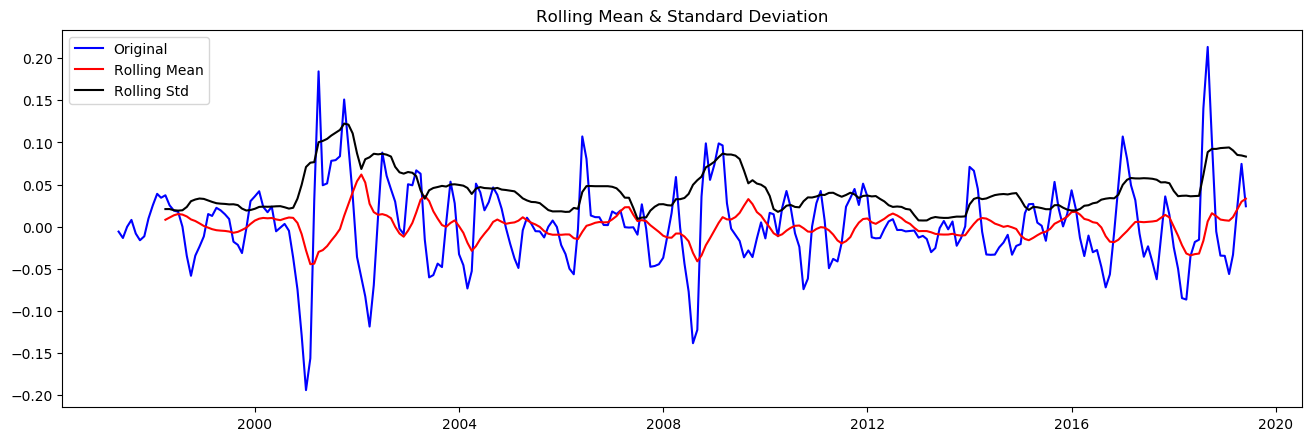

Results of Dickey-Fuller Test:
Test Statistic                -6.266597e+00
p-value                        4.099654e-08
#Lags Used                     1.500000e+01
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


In [19]:
# Trend ve mevsimsellikten arındırma

ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(16,5), dpi=100)
plt.plot(ts_log_diff)

plt.figure(figsize=(16,5), dpi=100)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.figure(figsize=(16,5), dpi=100)
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

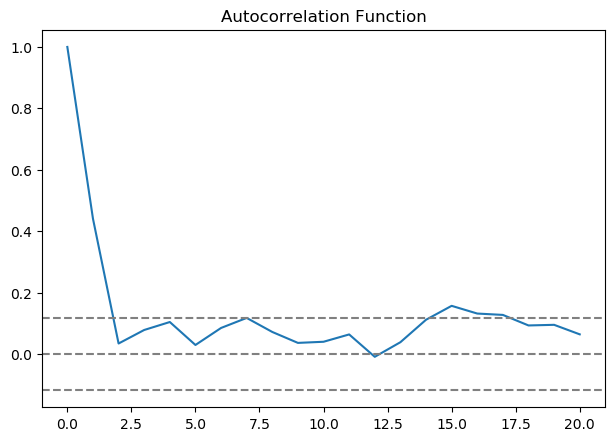

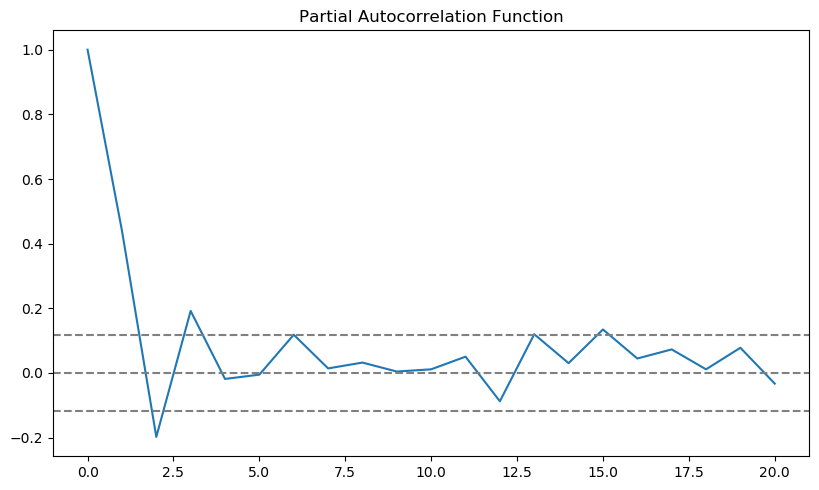

In [20]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.figure(figsize=(16,5), dpi=100)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.figure(figsize=(16,5), dpi=100)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [21]:
# Önce ARIMA modelini yüklemeliyiz
from statsmodels.tsa.arima_model import ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.3969')

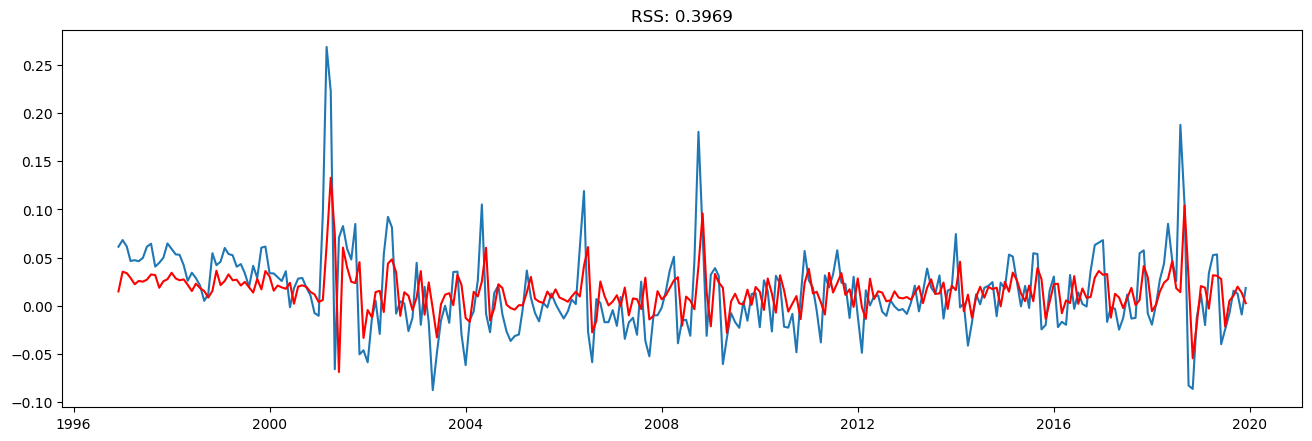

In [22]:
# AR model
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)
plt.figure(figsize=(16,5), dpi=100)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.3873')

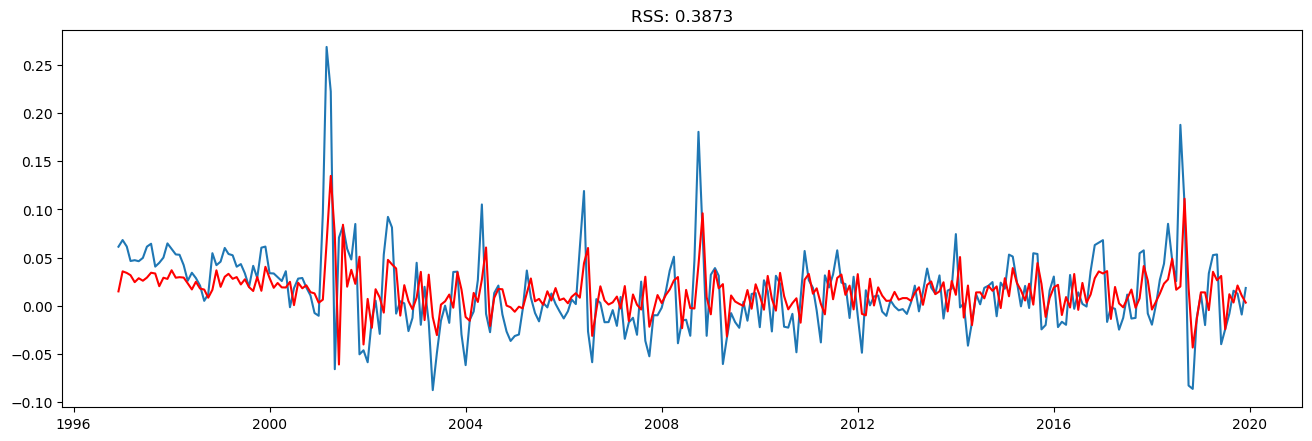

In [23]:
# MA Model
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)
plt.figure(figsize=(16,5), dpi=100)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Tarih
1996-12-01    0.018483
1997-01-01    0.038553
1997-02-01    0.038954
1997-03-01    0.037943
1997-04-01    0.032112
dtype: float64
Tarih
1996-12-01    0.018483
1997-01-01    0.057036
1997-02-01    0.095990
1997-03-01    0.133932
1997-04-01    0.166045
dtype: float64


NameError: name 'forecast' is not defined

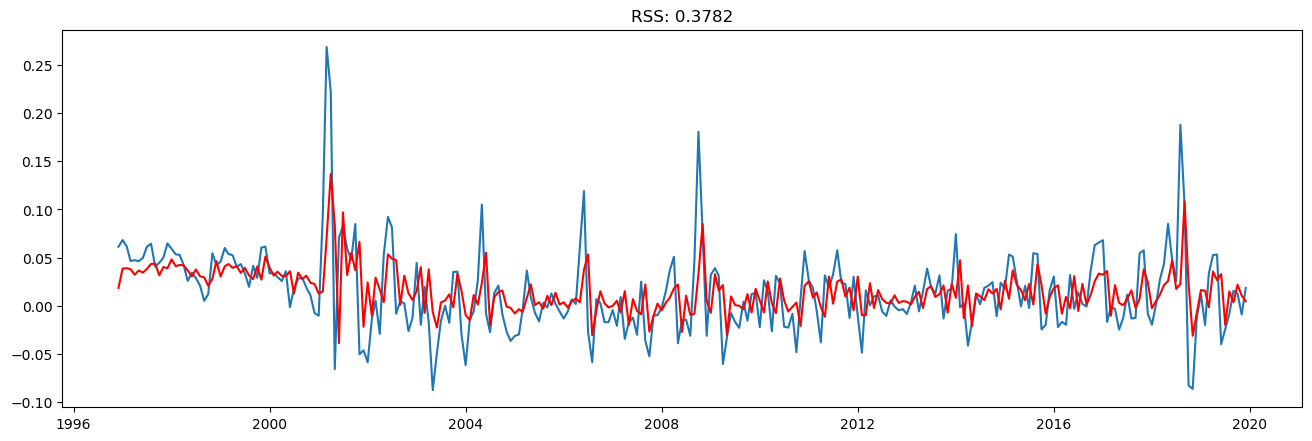

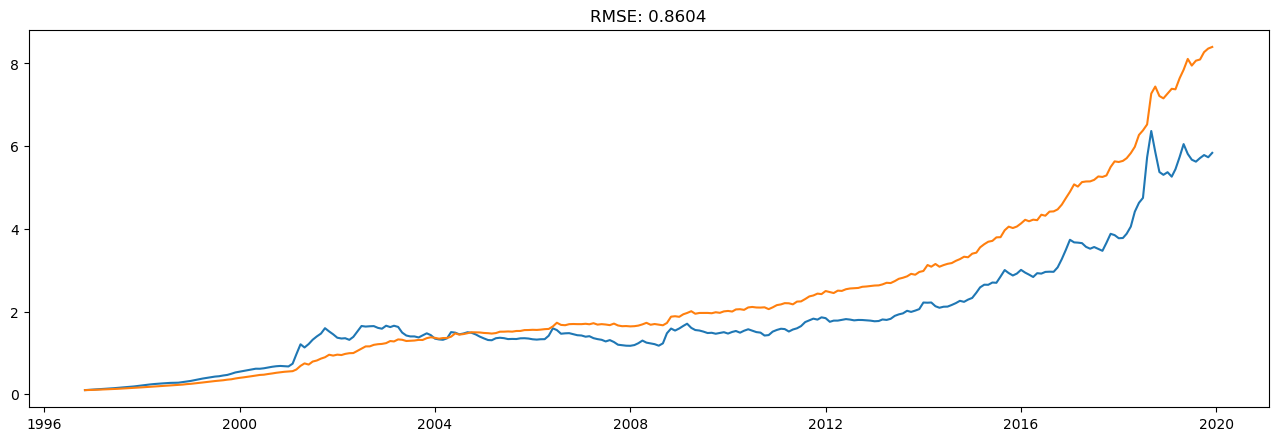

In [24]:
# Kombine Model
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1) 
plt.figure(figsize=(16,5), dpi=100) 
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

predictions_ARIMA_log = pd.Series(ts_log[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

fts = forecast(arimats, level = c(95))
autoplot(fts)
